In [49]:
# from __future__ import division
import env
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import utilities as utils


%matplotlib inline

In [47]:
grocery_query = """
SELECT *
    FROM grocery_customers
"""

grocery_df = utils.generate_df("grocery.csv", grocery_query, \
                               utils.generate_db_url(env.user, env.password, env.host, "grocery_db"))

In [7]:
grocery_df.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [8]:
grocery_df.set_index('customer_id', inplace=True)
grocery_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867


In [9]:
train, validate, test = utils.split_dataframe(grocery_df)

In [13]:
scale_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train[scale_cols], validate[scale_cols],\
                                                                          test[scale_cols])

In [15]:
train_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.054548,0.131106,0.147987,0.005397,0.218706,0.058010
1,0.048236,0.044440,0.026188,0.012849,0.023517,0.031685
2,0.236488,0.023522,0.043247,0.174543,0.012297,0.037234
3,0.081813,0.338874,0.178162,0.000000,0.170276,0.008970
4,0.046577,0.016513,0.014109,0.029314,0.012469,0.009700


In [16]:
train_scaled.reset_index(inplace=True)

train_scaled.rename(columns={'index' : 'customer_id'}, inplace=True)

train_scaled.set_index('customer_id', inplace=True)

## Using DBSCAN

In [27]:
np_array = train_scaled.values.astype("float32", copy=False)

dbsc = DBSCAN(eps=.10, min_samples=20).fit(np_array)

In [32]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(train_scaled.columns)
scaled_columns = ["Scaled_" + column for column in columns]

train_scaled.columns = scaled_columns

In [35]:
train = pd.merge(train, train_scaled, on=train.index)

In [37]:
train.drop(columns=['key_0'], inplace=True)

In [38]:
train

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Milk,Scaled_Grocery,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,1,3062,6154,13916,230,8933,2784,0.054548,0.131106,0.147987,0.005397,0.218706,0.058010
1,1,3,2708,2160,2642,502,965,1522,0.048236,0.044440,0.026188,0.012849,0.023517,0.031685
2,1,3,13265,1196,4221,6404,507,1788,0.236488,0.023522,0.043247,0.174543,0.012297,0.037234
3,2,3,4591,15729,16709,33,6956,433,0.081813,0.338874,0.178162,0.000000,0.170276,0.008970
4,1,3,2615,873,1524,1103,514,468,0.046577,0.016513,0.014109,0.029314,0.012469,0.009700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,1,3,8533,5506,5160,13486,1377,1498,0.152107,0.117045,0.053391,0.368565,0.033609,0.031185
242,2,3,10362,9232,11009,737,3537,2342,0.184722,0.197895,0.116581,0.019287,0.086522,0.048790
243,2,3,4048,5164,10391,130,813,179,0.072130,0.109624,0.109905,0.002657,0.019793,0.003671
244,2,3,15168,10556,12477,1920,6506,714,0.270422,0.226625,0.132441,0.051697,0.159252,0.014831


In [39]:
labels = dbsc.labels_
labels[0:10]

array([ 0,  0, -1, -1,  0,  0, -1,  0, -1,  0])

In [41]:
train['labels'] = labels
train.labels.value_counts()

 0    151
-1     95
Name: labels, dtype: int64

In [42]:
train[train.labels == -1].head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Milk,Scaled_Grocery,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
2,1,3,13265,1196,4221,6404,507,1788,0.236488,0.023522,0.043247,0.174543,0.012297,0.037234,-1
3,2,3,4591,15729,16709,33,6956,433,0.081813,0.338874,0.178162,0.000000,0.170276,0.008970,-1
6,1,3,29729,4786,7326,6130,361,1083,0.530074,0.101421,0.076792,0.167037,0.008721,0.022528,-1
8,2,3,21465,7243,10685,880,2386,2749,0.382710,0.154736,0.113081,0.023205,0.058326,0.057280,-1
13,2,3,21217,6208,14982,3095,6707,602,0.378288,0.132277,0.159504,0.083888,0.164176,0.012495,-1


In [43]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(train.describe())
print("-------------")
print("Inliers")
print(train[train.labels==0].describe())
print("-------------")
print("Outliers")
print(train[train.labels==-1].describe())

Population
          Channel      Region         Fresh          Milk       Grocery  \
count  246.000000  246.000000    246.000000    246.000000    246.000000   
mean     1.321138    2.569106  11160.243902   5662.804878   7972.032520   
std      0.467866    0.767517  10938.987241   6565.928893  10387.188297   
min      1.000000    1.000000      3.000000    112.000000    218.000000   
25%      1.000000    2.000000   2927.500000   1515.750000   2149.000000   
50%      1.000000    3.000000   7811.000000   3684.500000   4829.000000   
75%      2.000000    3.000000  15599.000000   7079.500000  10284.500000   
max      2.000000    3.000000  56082.000000  46197.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  Scaled_Fresh  \
count    246.000000        246.000000    246.000000    246.000000   
mean    2522.768293       2868.939024   1485.272358      0.198956   
std     3557.961083       5247.338332   3300.707690      0.195064   
min       33.000000          5.000000

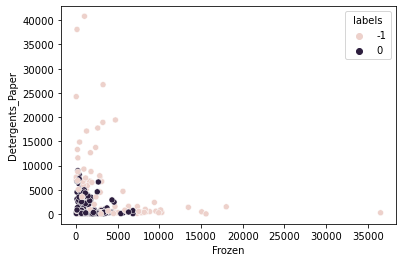

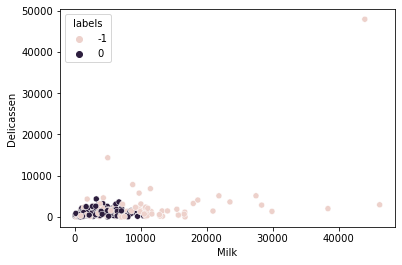

In [44]:
sns.scatterplot(train.Frozen, train.Detergents_Paper, hue=train.labels)
plt.show()

sns.scatterplot(train.Milk, train.Delicassen, hue=train.labels)
plt.show()

## 3D Modeling

In [51]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(train.Frozen, train.Detergents_Paper, train.Grocery,
           c=train.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')

## Tuning EPS

https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator

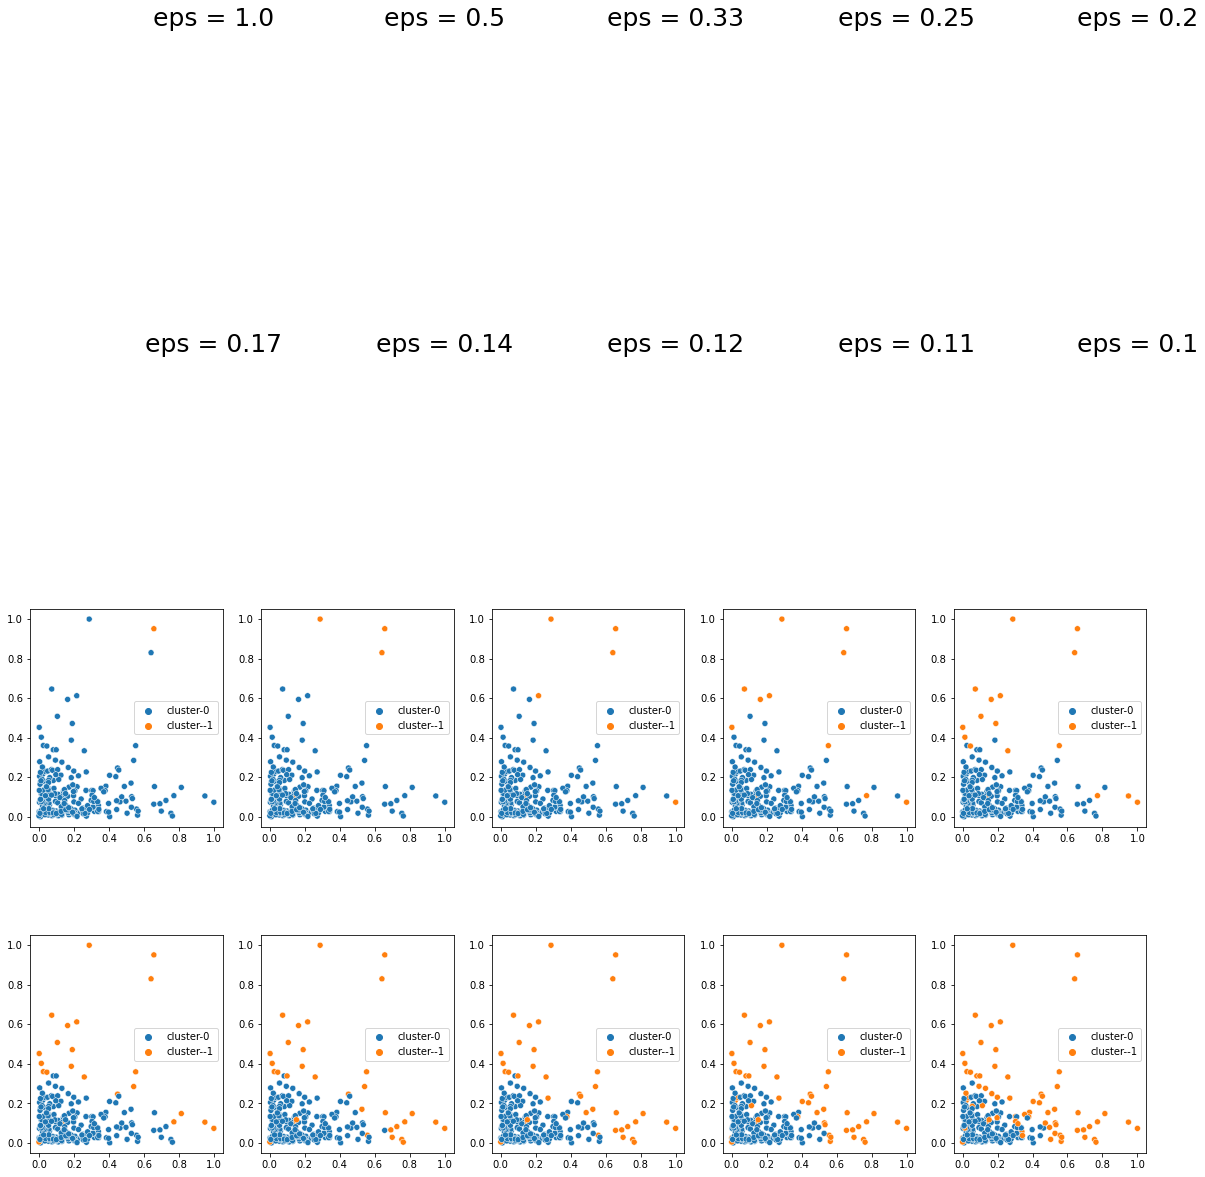

In [53]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=10).fit(np_array)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 2)), fontsize=25, ha="center")
    sns.scatterplot(np_array[:,0], np_array[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1

Text(0, 0.5, 'Distance')

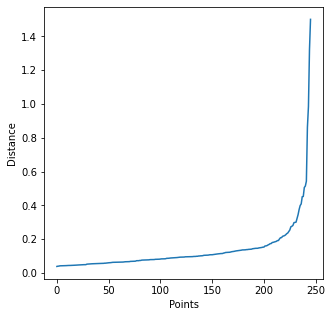

In [56]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(np_array)
distances, indices = neighbors.kneighbors(np_array)

distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.2172362222340953


<Figure size 360x360 with 0 Axes>

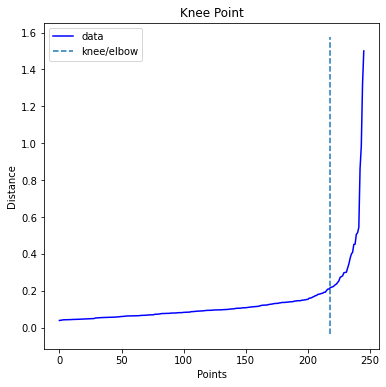

In [57]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

<AxesSubplot:>

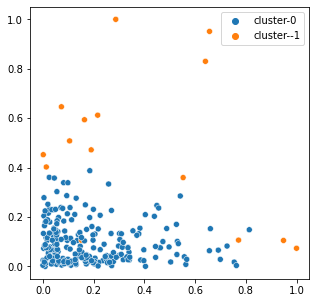

In [58]:
db = DBSCAN(eps=distances[knee.knee], min_samples=10).fit(np_array)
labels = db.labels_

fig = plt.figure(figsize=(5, 5))
sns.scatterplot(np_array[:,0], np_array[:,1], hue=["cluster-{}".format(x) for x in labels])